# Imports:

In [1]:
# Import necessary libraries and the custom optimizer

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 

import jax.numpy as jnp
from jax import config
import dynamiqs as dq
import tensorflow as tf

import utilities as utl
from load_and_plot import plot_evolution
from optimizers import HardwareAwareOptimizer

%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", False)
tf.keras.backend.set_floatx('float32')
dq.set_progress_meter(False)

%matplotlib qt

# Set a global seed for reproducible results
seed_value = 44
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
mpl.rcParams['figure.raise_window'] = False

# Pre-training:

In [2]:
# Load a pulse obtained from gradient descent
# It should be a numpy array of shape (4, n_pulse_points)
print("Loading a sample pulse for pre-training...")

directory = '/Users/saswataroy/OptimalControl/pulses/'
data = np.load(directory + 'fock_2_prep.npz')
amps = data["arr_0"]

ideal_pulse = amps

print("Sample pulse loaded.")

Loading a sample pulse for pre-training...
Sample pulse loaded.


In [3]:
# DEFINE SIMULATION AND PHYSICS PARAMETERS
fourier_scale = 12
# Instantiate the main optimizer class
# Define the scaling factors for the output layer.
# These values multiply the standard Glorot-initialized weights.
# Format: (I_cavity, Q_cavity, I_qubit, Q_qubit)
init_scales = (5.0, 5.0, 12.0, 12.0)

# Simulation parameters
osc_drive_type = 'linear'
ncav = 15  # Hilbert space dimension for the oscillator
ntr = 2    # Hilbert space dimension for the transmon

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = -0.0242 * (2 * np.pi)  * 0
chi = -3.649 * (2 * np.pi)
chi_prime = +0.039 * (2 * np.pi)

# Pulse parameters
T = 0.6  # Total pulse time in microseconds
ntsave = 601
ntpulse = 601
max_amp = 5 * np.pi * 2 # Max amplitude for the drives
max_freq = 25 # Max frequency component in MHz (+- max_freq is allowed)

# SETUP HAMILTONIAN, STATES, AND OPERATORS ---
# Operators
a, adag = dq.destroy(ncav), dq.create(ncav)
t, tdag = dq.destroy(ntr), dq.create(ntr)
idcav, idtr = dq.eye(ncav), dq.eye(ntr)

# Define Binomial codewords and errorwords
L0 = (dq.basis(ncav, 0) + dq.basis(ncav, 4)) / jnp.sqrt(2)
L1 = dq.basis(ncav, 2)

plus_X = dq.unit((L0 + L1) / jnp.sqrt(2)) 
minus_X = dq.unit((L0 - L1) / jnp.sqrt(2))
plus_Y = dq.unit((L0 + 1j*L1) / jnp.sqrt(2)) 
minus_Y = dq.unit((L0 - 1j*L1) / jnp.sqrt(2))

# Error words:
E0 = dq.basis(ncav, 3)
E1 = dq.basis(ncav, 1)
E_plus_X = dq.unit((E0 + E1) / jnp.sqrt(2))
E_minus_X = dq.unit((E0 - E1) / jnp.sqrt(2))
E_plus_Y = dq.unit((E0 + 1j*E1) / jnp.sqrt(2))
E_minus_Y = dq.unit((E0 - 1j*E1) / jnp.sqrt(2))

psi0 = [dq.tensor(dq.basis(ncav,0), dq.basis(ntr,0))]

exp_ops = [dq.tensor(dq.proj(dq.basis(ncav,2)), dq.proj(dq.basis(ntr,0)))]

# Time arrays
tsave = jnp.linspace(0.0, T, ntsave, dtype = jnp.float32)
tpulse = jnp.linspace(0.0, T, ntpulse, dtype = jnp.float32)

# Static Hamiltonian
H0 = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
     (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t)

# Create the master parameter dictionary
my_params = {'H0': H0, 
             'ncav': ncav, 
             'ntr': ntr, 
             'alpha': alpha, 
             'K': K, 
             'chi': chi,
             'chi_prime': chi_prime, 
             'T': T, 
             'ntsave': ntsave, 
             'ntpulse': ntpulse,
             'max_amp': max_amp, 
             'max_freq': max_freq, 
             'psi0': psi0, 
             'exp_ops': exp_ops, 
             'tsave': tsave, 
             'tpulse': tpulse, 
             'osc_drive': osc_drive_type,
             'fourier_scale':fourier_scale,
             'init_scales':init_scales}

In [4]:
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)

Initializing Optimizer...
Neural network model created.


In [5]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,  # How often to decay
    decay_rate=0.95)   # How much to decay by

# Pre-train the network on the GRADIENT descent generated pulse
optimizer.pre_train(
    ideal_pulse_arrays=ideal_pulse,
    time_array=my_params['tpulse'][:-1],
    epochs= 75000,
    learning_rate=1e-3
)


--- Starting Pre-training ---


Pre-training:  17%|█▋        | 12860/75000 [04:40<22:34, 45.87it/s]


Target MSE of 0.001 reached at epoch 12860. Stopping pre-training.
Pre-training finished. Final MSE Loss: 0.000950


Verifying the pre-trained pulse...
Generating pulse from the trained model...
Mean Squared Error (NN vs Ideal): 0.000936


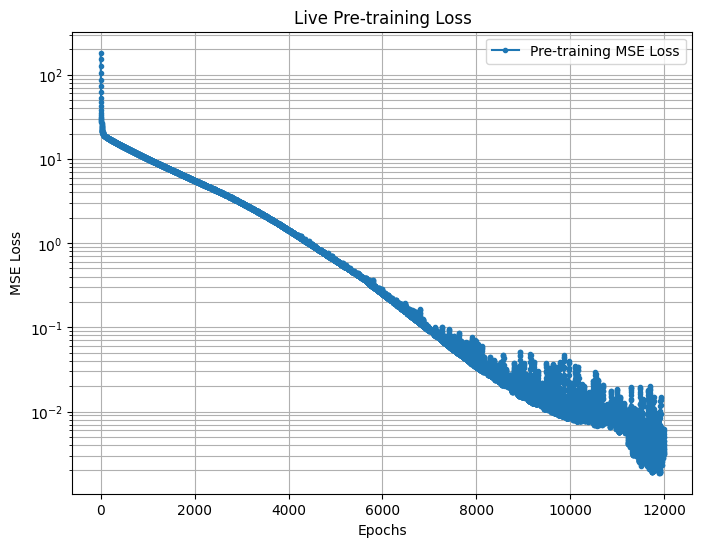

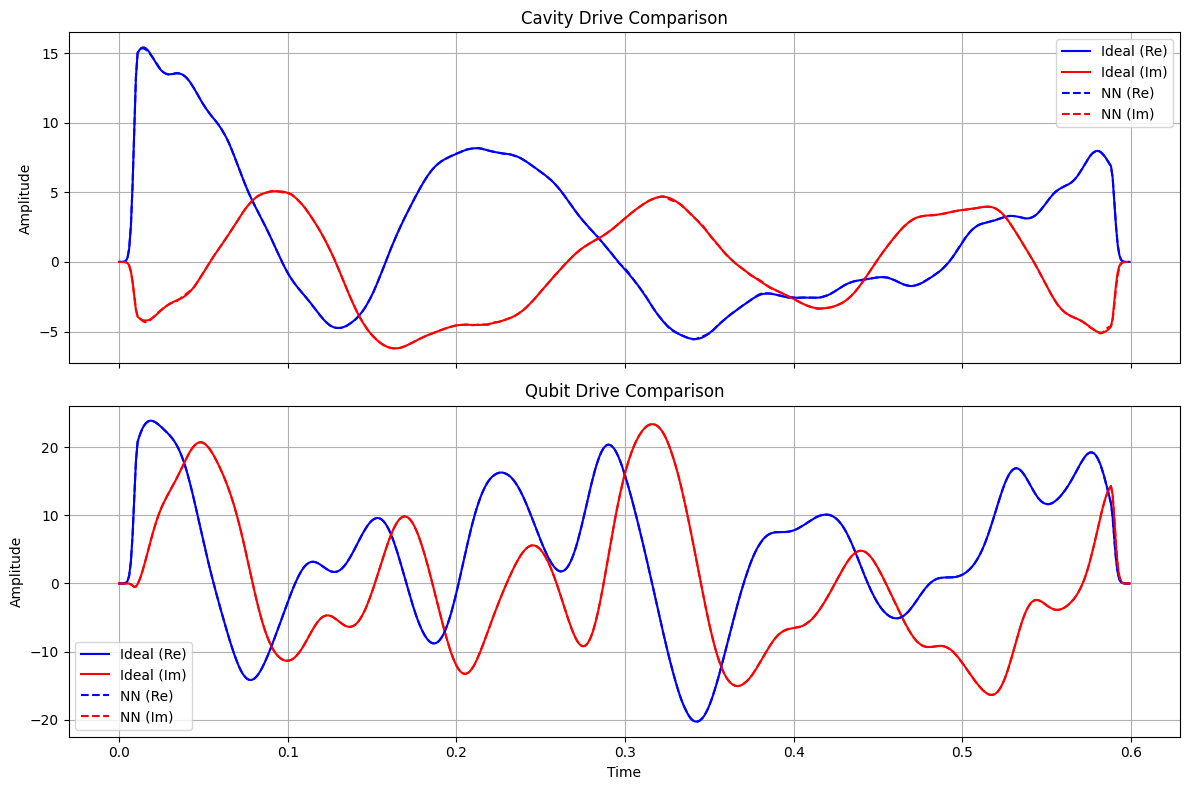

In [6]:
%matplotlib inline
print("Verifying the pre-trained pulse...")

# Prepare the time vector input for the model
time_array = my_params['tpulse'][:-1]
time_input = tf.constant(time_array, dtype=tf.float64)
time_input = tf.reshape(time_input, (1, len(time_array), 1))

# Generate a pulse from the trained network
generated_pulse_np = optimizer.generate_pulse()

ideal_pulse_complex = amps

# Numerically compare by calculating the Mean Squared Error
mse = np.mean(np.abs(np.square(generated_pulse_np - ideal_pulse_complex)))
print(f"Mean Squared Error (NN vs Ideal): {mse:.6f}")

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(ideal_pulse_complex[0, :]), 'b-', label='Ideal (Re)')
axs[0].plot(time_array, np.imag(ideal_pulse_complex[0, :]), 'r-', label='Ideal (Im)')
axs[0].plot(time_array, np.real(generated_pulse_np[0, :]), 'b--', label='NN (Re)')
axs[0].plot(time_array, np.imag(generated_pulse_np[0, :]), 'r--', label='NN (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(ideal_pulse_complex[1, :]), 'b-', label='Ideal (Re)')
axs[1].plot(time_array, np.imag(ideal_pulse_complex[1, :]), 'r-', label='Ideal (Im)')
axs[1].plot(time_array, np.real(generated_pulse_np[1, :]), 'b--', label='NN (Re)')
axs[1].plot(time_array, np.imag(generated_pulse_np[1, :]), 'r--', label='NN (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

%matplotlib qt

In [7]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'pretrained_fock2'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/pretrained_fock2_2025-10-13_13-27-37.weights.h5
'/Users/saswataroy/OptimalControl/pulses/pretrained_fock2_2025-10-13_13-27-37.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/pretrained_fock2_2025-10-13_13-27-37.npz'

Trained model is saved and ready for hardware SPSA tuning


# Offline Training:

In [8]:
# Load the optimizer
# directory = '/Users/saswataroy/OptimalControl/pulses/'
# optimizer = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)
optimizer.load_model_weights(directory + 'pretrained_fock2_2025-10-13_13-27-37.weights.h5')
print('\n Model loaded, pre-training skipped')

# Or Initialize the optimizer:
# optimizer = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)

Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/pretrained_fock2_2025-10-13_13-27-37.weights.h5

 Model loaded, pre-training skipped


In [4]:
def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

# Check the performance of pulse generated by a loaded model
print(loss_calculator_func(optimizer.generate_pulse(), my_params))

Generating pulse from the trained model...
0.99917656


In [5]:
# Run the optimizer
optimizer.fine_tune_simulation(
    loss_calculator_func=loss_calculator_func,
    epochs=30000,
    learning_rate=1e-4
)


--- Starting Simulation Fine-tuning ---


Sim-tuning:   3%|▎         | 893/30000 [06:06<3:18:59,  2.44it/s]


Target fidelity loss of 0.001 reached at epoch 893. Stopping fine-tuning.
Simulation fine-tuning finished. Final Fidelity Loss: 0.000998


In [17]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'offline_trained_fock2'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-14_13-04-43.weights.h5
'/Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-14_13-04-43.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-14_13-04-43.npz'

Trained model is saved and ready for hardware SPSA tuning


## Robustness calculation: 

In [13]:
def build_robustness_tensors(params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav, idtr = dq.eye(params['ncav']), dq.eye(params['ntr'])

    # Define variations in MHz
    chi_variations_mhz = jnp.array([-3.649, -3.649 - 0.1, -3.649 + 0.1], dtype=jnp.float32)
    qb_dets_variations_mhz = jnp.array([0, -0.25, +0.25], dtype=jnp.float32)

    # Get constant parameters
    alpha = jnp.float32(params['alpha'])
    chi_prime = jnp.float32(params['chi_prime'])
    K = jnp.float32(params['K'])
    pi_32 = jnp.float32(jnp.pi)

    # Build a Batch of the static Hamiltonians and detuning phasors
    H0_batch_list = []
    qbdet_batch_list = []
    
    for chi_mhz in chi_variations_mhz:
        for qb_det_mhz in qb_dets_variations_mhz:
            chi = chi_mhz * (2 * pi_32)
            H0_sample = (chi * dq.tensor(adag @ a, tdag @ t) +
                         (K / 2) * dq.tensor(adag @ adag @ a @ a, idtr) +
                         (alpha / 2) * dq.tensor(idcav, tdag @ tdag @ t @ t) +
                         (chi_prime / 2) * dq.tensor(adag @ adag @ a @ a, tdag @ t))
            H0_batch_list.append(H0_sample)

            qb_det = qb_det_mhz * (2 * pi_32)
            qb_det_phase = qb_det * params['tpulse'][:-1]
            phasor = jnp.exp(-1j * qb_det_phase)
            qbdet_batch_list.append(phasor)

    return {
        'H0_batch': dq.stack(H0_batch_list),
        'qbdet_batch': jnp.stack(qbdet_batch_list)
    }

robustness_tensors = build_robustness_tensors(my_params)
my_params.update(robustness_tensors)

In [14]:
# Load the optimizer
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer.load_model_weights(directory + 'offline_trained_fock2_2025-10-13_13-29-04.weights.h5')
print('\n Model loaded, pre-training skipped')
print(loss_calculator_func(optimizer.generate_pulse(), my_params))

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-13_13-29-04.weights.h5

 Model loaded, pre-training skipped
Generating pulse from the trained model...
0.0008906722


In [15]:
def robust_loss_calculator(amps, params, robustness_weight=0.85):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav, idtr = dq.eye(params['ncav']), dq.eye(params['ntr'])
    psi0, tsave, exp_ops = params['psi0'], params['tsave'], params['exp_ops']
    
    # Fetch pre-calculated tensors from the params dictionary
    H0_batch = params['H0_batch']
    qbdet_batch = params['qbdet_batch']
    
    # Build the time-dependent part of the Hamiltonian
    if params['osc_drive'] == 'linear': osc_pow = 1
    else: osc_pow = 2
    
    det_qb_drive_batch = amps[1,:] * qbdet_batch  # Broadcasting (B, N) = (N,) * (B, N)

    # Broadcast the common cavity drive to match the batch shape
    cavity_drive_amps = amps[0,:]
    cavity_drive_amps_batch = jnp.broadcast_to(cavity_drive_amps, det_qb_drive_batch.shape)

    # Construct the full batched Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(cavity_drive_amps_batch), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.imag(cavity_drive_amps_batch), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(det_qb_drive_batch), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.imag(det_qb_drive_batch), -1j * dq.tensor(idcav, (t - tdag)))

    H_total_batch = H0_batch + Hcr + Hci + Htr + Hti

    # Perform Simulation and Calculate Loss
    options = dq.Options(progress_meter=None)
    solver = dq.method.Tsit5(max_steps=int(1e9))
    batch_evo_result = dq.sesolve(
        H_total_batch, psi0, tsave, exp_ops=exp_ops, options=options, method=solver
    )

    all_expects_final = batch_evo_result.expects[...,-1].real
    num_psi = all_expects_final.shape[1]

    traces = jnp.trace(all_expects_final, axis1=1, axis2=2)
    central_fidelity = traces[0] / num_psi
    robust_fidelity = jnp.mean(traces) / num_psi
    
    weighted_fidelity = (central_fidelity + robustness_weight * robust_fidelity) / (1 + robustness_weight)
    
    # if central_fidelity > 0.999:
    #     total_infidelity = 1 - central_fidelity
    # else:
    #     total_infidelity = 1.0 - weighted_fidelity
    
    total_infidelity = 1 - weighted_fidelity

    return jnp.real(total_infidelity)

In [16]:
# %matplotlib qt
# mpl.rcParams['figure.raise_window'] = False

optimizer.fine_tune_simulation(
    loss_calculator_func=robust_loss_calculator,
    epochs=15000,
    learning_rate=5e-4, 
    update_plot_every = 25
)


--- Starting Simulation Fine-tuning ---


Sim-tuning:  22%|██▏       | 3236/15000 [2:52:43<9:58:54,  3.05s/it] 2025-10-14 12:58:10.374976: W tensorflow/core/framework/op_kernel.cc:1842] UNKNOWN: KeyboardInterrupt: 
Traceback (most recent call last):

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/ops/script_ops.py", line 142, in __call__
    outputs = self._call(device, args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/saswataroy/OptimalControl/NN_OptimalControl/optimizers.py", line 354, in _get_loss_and_grad_from_jax_wrapper
    loss, grad = jax.value

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyboardInterrupt: 
Traceback (most recent call last):

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/ops/script_ops.py", line 142, in __call__
    outputs = self._call(device, args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/saswataroy/OptimalControl/NN_OptimalControl/optimizers.py", line 354, in _get_loss_and_grad_from_jax_wrapper
    loss, grad = jax.value_and_grad(loss_calculator_func)(amps_jax, self.params)
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/api.py", line 479, in value_and_grad_f
    ans, vjp_py = _vjp(f_partial, *dyn_args)
                  ~~~~^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/api.py", line 2144, in _vjp
    out_primals, vjp = ad.vjp(flat_fun, primals_flat)
                       ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 312, in vjp
    out_primals, pvals, jaxpr, consts = linearize(traceable, *primals)
                                        ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 286, in linearize
    return direct_linearize(traceable, primals, kwargs, has_aux=has_aux)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 259, in direct_linearize
    ans = traceable.call_wrapped(*tracers)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
    return self.f_transformed(*args, **kwargs)
           ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/api_util.py", line 90, in flatten_fun_nokwargs
    ans = f(*py_args)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/api_util.py", line 288, in _argnums_partial
    return _fun(*args, **kwargs)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/linear_util.py", line 397, in _get_result_paths_thunk
    ans = _fun(*args, **kwargs)

  File "/var/folders/g9/p3v1clmd6r5g0kyspz6w0g300000gn/T/ipykernel_5518/319361552.py", line 33, in robust_loss_calculator
    batch_evo_result = dq.sesolve(
        H_total_batch, psi0, tsave, exp_ops=exp_ops, options=options, method=solver
    )

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/dynamiqs/integrators/apis/sesolve.py", line 204, in sesolve
    return _vectorized_sesolve(H, psi0, tsave, exp_ops, method, gradient, options)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/dynamiqs/integrators/_utils.py", line 56, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/pjit.py", line 270, in cache_miss
    executable, pgle_profiler, const_args) = _python_pjit_helper(
                                             ~~~~~~~~~~~~~~~~~~~^
        fun, jit_info, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/pjit.py", line 152, in _python_pjit_helper
    out_flat = jit_p.bind(*args_flat, **p.params)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 612, in bind
    return self._true_bind(*args, **params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 628, in _true_bind
    return self.bind_with_trace(prev_trace, args, params)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 638, in bind_with_trace
    return trace.process_primitive(self, args, params)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 891, in process_primitive
    primal_out, tangent_nzs_out, residuals, linearized = lin(
                                                         ~~~^
        tangent_nzs, *primals_in, **params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/pjit.py", line 2299, in _pjit_linearize
    ans = jit_p.bind(*primals_in, jaxpr=primal_jaxpr,
                     in_shardings=in_shardings,
    ...<7 lines>...
                     inline=inline,
                     compiler_options_kvs=compiler_options_kvs)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 612, in bind
    return self._true_bind(*args, **params)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 628, in _true_bind
    return self.bind_with_trace(prev_trace, args, params)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 638, in bind_with_trace
    return trace.process_primitive(self, args, params)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/core.py", line 1162, in process_primitive
    return primitive.impl(*args, **params)
           ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/pjit.py", line 1853, in _pjit_call_impl
    return xc._xla.pjit(
           ~~~~~~~~~~~~~
        name, f, call_impl_cache_miss, [], [], cache_key,
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        tree_util.dispatch_registry, pxla.cc_shard_arg,
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        _get_cpp_global_cache(cache_key.contains_explicit_attributes))(*args)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/pjit.py", line 1829, in call_impl_cache_miss
    out_flat, compiled, pgle_profiler, const_args = _pjit_call_impl_python(
                                                    ~~~~~~~~~~~~~~~~~~~~~~^
        *args, jaxpr=jaxpr, in_shardings=in_shardings,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<2 lines>...
        ctx_mesh=ctx_mesh, name=name, keep_unused=keep_unused,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        inline=inline, compiler_options_kvs=compiler_options_kvs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/pjit.py", line 1804, in _pjit_call_impl_python
    return (compiled.unsafe_call(*computation.const_args, *args),
            ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/profiler.py", line 364, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/envs/optctrl/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1353, in __call__
    results = self.xla_executable.execute_sharded(
        input_bufs, with_tokens=True
    )

KeyboardInterrupt

 [Op:EagerPyFunc] name: 

In [13]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'offline_trained_fock2_robust_chi_qbdet'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_robust_chi_qbdet_2025-10-13_16-51-56.weights.h5
'/Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_robust_chi_qbdet_2025-10-13_16-51-56.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_robust_chi_qbdet_2025-10-13_16-51-56.npz'

Trained model is saved and ready for hardware SPSA tuning


# SPSA testing in simulation:

In [47]:
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
# optimizer.load_model_weights(directory + 'offline_trained_fock2_noseed_2025-10-13_15-09-42.weights.h5') # This is the NN generated pulse
# optimizer.load_model_weights(directory + 'offline_trained_fock2_2025-10-14_13-04-43.weights.h5') # This is robust pulse 
optimizer.load_model_weights(directory + 'offline_trained_fock2_2025-10-13_13-29-04.weights.h5') # This is grape+NN pulse
print('\nModel loaded, proceed to SPSA hardware tuning')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-13_13-29-04.weights.h5

Model loaded, proceed to SPSA hardware tuning


In [48]:
# Optional: Sanity check: check the fidelity of the loaded pulse
loss_calculator_func(optimizer.generate_pulse(), my_params)

Generating pulse from the trained model...


Array(0.00089067, dtype=float32)

In [49]:
my_test_params = my_params.copy()

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = (-0.0242  ) * (2 * np.pi) *0
chi = (-3.649 ) * (2 * np.pi)
chi_prime = (+0.039 + 0.0) * (2 * np.pi)

# Detuning on qubit and cavity drives
det_osc = 0.04*(2*np.pi)*0
det_qb = -0.04*(2*np.pi)*0

drift_rate = 0.229 * 2 * np.pi
drift_values = drift_rate * my_test_params['tpulse'][:-1]
H_drift = dq.pwc(my_test_params['tpulse'], drift_values, dq.tensor(adag @ a, idtr))

my_test_params['H0'] = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
        (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t) + H_drift

def spsa_test_loss_calculator(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    # add measurement noise to fidelity calculation
    measurement_noise = 0.5*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

T1q = 70
T2q = 30
Tphiq = (1/T2q - 1/(2*T1q))**(-1)

T1c = 200
T2c = 280
Tphic = (1/T2c - 1/(2*T1c))**(-1)

c_ops = [
        jnp.sqrt(1/T1q)*dq.tensor(idcav, t),
        jnp.sqrt(1/Tphiq)*dq.tensor(idcav, tdag @ t),
        jnp.sqrt(1/T1c)*dq.tensor(a, idtr), 
        jnp.sqrt(1/Tphic)*dq.tensor(adag @ a, idtr),
        ]

exp_state = [dq.tensor(dq.basis(ncav,2), dq.basis(ntr,0))]
exp_code_dm_list = [psi @ psi.dag() for psi in exp_state]
exp_code_dm = dq.stack(exp_code_dm_list)

my_params['T1q'] = T1q
my_params['T2q'] = T2q
my_params['T1c'] = T1c
my_params['T2c'] = T2c
my_params['c_ops'] = c_ops
my_params['exp_state'] = exp_state
my_params['exp_code_dm'] = exp_code_dm

def spsa_test_loss_calculator_mesolve(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    # finals = evo_result.states[:,-1]
    # fid = jnp.mean(jax.vmap(lambda r, t: jnp.abs(dq.trace(r@t)), in_axes=(0,0))(finals, exp_code_dm))

   # add measurement noise to fidelity calculation
    measurement_noise = 0*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func_mesolve(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def fourier_transform_rows(amps_time: np.ndarray, dt: float = 1e-9):
    """
    Compute the FFT of each row of a 2×N time-domain array.
    
    Parameters
    ----------
    amps_time : np.ndarray, shape (2, N)
        Time-domain complex amplitudes (row 0 = oscillator, row 1 = qubit).
    dt : float
        Time step in seconds between samples (default 1e-9 s).
    
    Returns
    -------
    freqs : np.ndarray, shape (N,)
        Frequency bins in Hz, as returned by np.fft.fftfreq.
    eps_freq : np.ndarray, shape (2, N)
        Complex amplitudes in the frequency domain.
    """
    N = amps_time.shape[1]
    freqs = np.fft.fftfreq(N, d=dt)
    eps_freq = np.fft.fft(amps_time, axis=1)
    return freqs, eps_freq

def inverse_fourier_transform_rows(eps_mod: np.ndarray):
    """
    Inverse FFT to go back to a 2×N time-domain waveform.
    
    Parameters
    ----------
    eps_mod : np.ndarray, shape (2, N)
        Frequency-domain amplitudes (modified).
    
    Returns
    -------
    amps_time_mod : np.ndarray, shape (2, N)
        Complex time-domain amplitudes, at the original 1 ns sampling.
    """
    amps_time_mod = np.fft.ifft(eps_mod, axis=1)
    return amps_time_mod

def dispersion_tuning(amps: np.ndarray,
                        b_osc: float, b_qb: float,
                        tau_osc: float, tau_qb: float,
                        dt: float = 1e-9) -> np.ndarray:
    freqs, eps_freq = fourier_transform_rows(amps, dt=dt)

    ω = 2 * np.pi * freqs    
    f_osc = 1 + b_osc * ω * np.exp(1j * ω * tau_osc)
    f_qb  = 1 + b_qb  * ω * np.exp(1j * ω * tau_qb)
    
    factors = np.vstack([f_osc, f_qb])  

    eps_mod = eps_freq * factors       

    amps_mod = inverse_fourier_transform_rows(eps_mod)
    return amps_mod  


def spsa_test_loss_calculator_dispersion_mesolve(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # add frequency dependent drive amplitude: 
    amps = dispersion_tuning(amps, 0, -0.0015*1e-6, 0, 0)

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.01, 0.01, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    noisy_amps = amps_real_noisy + 1j * amps_imag_noisy

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    # finals = evo_result.states[:,-1]
    # fid = jnp.mean(jax.vmap(lambda r, t: jnp.abs(dq.trace(r@t)), in_axes=(0,0))(finals, exp_code_dm))

   # add measurement noise to fidelity calculation
    measurement_noise = 1*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss


In [50]:
gen_pulse = optimizer.generate_pulse()
print("Generated pulse shape:", gen_pulse.shape)

# This gives the target or best possible scenario after SPSA optimization
print('\nfidelity without parameter deviations and losses:', 1 - loss_calculator_func(gen_pulse, my_params))
print('fidelity with losses but no parameter deviation:', 1 - loss_calculator_func_mesolve(gen_pulse, my_params))

# This is the starting point for SPSA: shows how much deviation we have
print('\nFidelity in experiment without losses before SPSA optimization:', 1 - spsa_test_loss_calculator(gen_pulse, my_test_params))
print('Fidelity in experiment with losses before SPSA optimization:', 1- spsa_test_loss_calculator_mesolve(gen_pulse, my_test_params))

# Experimental uncertainty included 
print('\nFidelity with dispersion included with losses before SPSA:', 1 - spsa_test_loss_calculator_dispersion_mesolve(gen_pulse, my_params))

Generating pulse from the trained model...
Generated pulse shape: (2, 600)

fidelity without parameter deviations and losses: 0.9991093
fidelity with losses but no parameter deviation: 0.9899281

Fidelity in experiment without losses before SPSA optimization: 0.97575843
Fidelity in experiment with losses before SPSA optimization: 0.968102

Fidelity with dispersion included with losses before SPSA: 0.95902246


In [51]:
# SPSA tuning biases and weights (with losses)
optimizer.fine_tune_hardware_spsa_all(
    test_loss_calculator=spsa_test_loss_calculator_mesolve,
    test_params=my_test_params,
    layer_name='final_hidden_layer',    # Specify the layer to tune
    spsa_steps=750,                 
    a=0.005,    # step size                    
    c=0.005,   # perturbation size
    update_plot_every=10,
    target_fidelity_loss=1e-3
)


--- Starting Hardware Fine-tuning (SPSA on ALL weights of layer: final_hidden_layer) ---
Targeting 260 parameters in layer 'final_hidden_layer'.
Initial loss before SPSA: 0.031898


SPSA Tuning (final_hidden_layer): 100%|██████████| 750/750 [01:54<00:00,  6.54it/s]


Optimization finished. Restoring best parameters found with loss: 0.012256


In [45]:
# # SPSA tuning biases only - does not work well (no losses)
# optimizer.fine_tune_hardware_spsa(
#     test_loss_calculator=spsa_test_loss_calculator,
#     test_params=my_test_params,
#     spsa_steps=5000,
#     a=0.01,  # SPSA step size
#     c=0.01,  # SPSA perturbation size
#     update_plot_every=10,
#     target_fidelity_loss=1e-3
# )

# print("\nSPSA simulation test complete.")

In [46]:
# # SPSA tuning biases and weights (no losses)
# optimizer.fine_tune_hardware_spsa_all(
#     test_loss_calculator=spsa_test_loss_calculator,
#     test_params=my_test_params,
#     layer_name='final_hidden_layer', # Specify the layer to tune
#     spsa_steps=1500,                 
#     a=0.01, # step size 
#     c=0.01, # perturbation size
#     update_plot_every=10,
#     target_fidelity_loss=1e-3
# )

In [60]:
spsa_pulse = optimizer.generate_pulse()
print("Generated pulse shape:", spsa_pulse.shape)
print('Fidelity in experiment after SPSA optimization:', spsa_test_loss_calculator(spsa_pulse, my_test_params))

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

time_array = my_params['tpulse'][:-1]

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(gen_pulse[0, :]), 'b-', label='sim (Re)')
axs[0].plot(time_array, np.imag(gen_pulse[0, :]), 'r-', label='sim (Im)')
axs[0].plot(time_array, np.real(spsa_pulse[0, :]), 'b--', label='SPSA (Re)')
axs[0].plot(time_array, np.imag(spsa_pulse[0, :]), 'r--', label='SPSA (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(gen_pulse[1, :]), 'b-', label='sim (Re)')
axs[1].plot(time_array, np.imag(gen_pulse[1, :]), 'r-', label='sim (Im)')
axs[1].plot(time_array, np.real(spsa_pulse[1, :]), 'b--', label='SPSA (Re)')
axs[1].plot(time_array, np.imag(spsa_pulse[1, :]), 'r--', label='SPSA (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Generating pulse from the trained model...
Generated pulse shape: (2, 600)
Fidelity in experiment after SPSA optimization: 0.006575995


In [50]:
# Save trained model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
base_filename = 'spsa_trained_fock2'

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

weights_filepath = directory + base_filename +'_'+ timestamp + '.weights.h5'
params_filepath = directory + base_filename + '_'+ timestamp + '.npz'

optimizer.save_model_weights(weights_filepath)
np.savez(params_filepath, **my_test_params)
print(repr(weights_filepath))
print(repr(params_filepath))

print("\nTrained model is saved and ready for hardware SPSA tuning")

Model weights saved successfully to /Users/saswataroy/OptimalControl/pulses/spsa_trained_fock2_2025-10-14_13-25-27.weights.h5
'/Users/saswataroy/OptimalControl/pulses/spsa_trained_fock2_2025-10-14_13-25-27.weights.h5'
'/Users/saswataroy/OptimalControl/pulses/spsa_trained_fock2_2025-10-14_13-25-27.npz'

Trained model is saved and ready for hardware SPSA tuning


In [ ]:
# Load model weights

directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_test_params, fourier_scale = fourier_scale)
optimizer.load_model_weights(directory + 'SPSA_tuned_model_non_robust.weights.h5')
print('\n SPSA-tuned model loaded, proceed to experiments')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/SPSA_tuned_model_non_robust.weights.h5

 SPSA-tuned model loaded, proceed to experiments


In [ ]:
# Sanity check:
spsa_test_loss_calculator_mesolve(optimizer.generate_pulse(), my_test_params)

Generating pulse from the trained model...


np.float32(0.014108717)

# Bayesian optimization 

In [4]:
# Load model weights
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer = HardwareAwareOptimizer(my_params, fourier_scale = 12)
optimizer.load_model_weights(directory + 'fock2_fine_tuned_model.weights.h5')
print('\nModel loaded, proceed to SPSA hardware tuning')

# Optional: Sanity check: check the fidelity of the loaded pulse
# loss_calculator_func(optimizer.generate_pulse(), my_params)

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/fock2_fine_tuned_model.weights.h5

Model loaded, proceed to SPSA hardware tuning


In [5]:
my_test_params = my_params.copy()

# Device parameters (in MHz, multiplied by 2*pi)
alpha = -165 * (2 * np.pi)
K = (-0.0242 + 0.02 ) * (2 * np.pi)
chi = (-3.649 - 0.35 ) * (2 * np.pi)
chi_prime = (+0.039 - 0.02) * (2 * np.pi)

# Detuning on qubit and cavity drives
det_osc = -0.025*(2*np.pi)
det_qb = -0.06*(2*np.pi)

my_test_params['H0'] = chi * dq.tensor(adag@a, tdag@t) + (K/2)*dq.tensor(adag@adag@a@a, idtr) + \
        (alpha/2)*dq.tensor(idcav, tdag@tdag@t@t) + (chi_prime/2)*dq.tensor(adag@adag@a@a, tdag@t)

def bo_test_loss_calculator(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    # add measurement noise to fidelity calculation
    measurement_noise = 0.5*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

T1q = 80
T2q = 80
Tphiq = (1/T2q - 1/(2*T1q))**(-1)

T1c = 200
T2c = 200
Tphic = (1/T2c - 1/(2*T1c))**(-1)

c_ops = [
        jnp.sqrt(1/T1q)*dq.tensor(idcav, t),
        jnp.sqrt(1/Tphiq)*dq.tensor(idcav, tdag @ t),
        jnp.sqrt(1/T1c)*dq.tensor(a, idtr), 
        jnp.sqrt(1/Tphic)*dq.tensor(adag @ a, idtr),
        ]

exp_state = [dq.tensor(dq.basis(ncav,2), dq.basis(ntr,0))]
exp_code_dm_list = [psi @ psi.dag() for psi in exp_state]
exp_code_dm = dq.stack(exp_code_dm_list)

my_params['T1q'] = T1q
my_params['T2q'] = T2q
my_params['T1c'] = T1c
my_params['T2c'] = T2c
my_params['c_ops'] = c_ops
my_params['exp_state'] = exp_state
my_params['exp_code_dm'] = exp_code_dm

def bo_test_loss_calculator_mesolve(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    # finals = evo_result.states[:,-1]
    # fid = jnp.mean(jax.vmap(lambda r, t: jnp.abs(dq.trace(r@t)), in_axes=(0,0))(finals, exp_code_dm))

    # add measurement noise to fidelity calculation
    measurement_noise = 0*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss

def loss_calculator_func_mesolve(amps, params):

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss


In [6]:
optimizer.fine_tune_hardware_bo(
    loss_calculator = bo_test_loss_calculator_mesolve, 
    test_params = my_test_params, 
    layer_name='final_hidden_layer',
    n_calls = 100,
    search_radius = 2.5,
    plot_live = True
)


--- Starting Hardware Fine-tuning (Bayesian Optimization on final_hidden_layer) ---
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating pulse from the trained model...
Generating p

AttributeError: 'StopIteration' object has no attribute 'x'

# Analysis: 

## Dynamics and pulse

In [ ]:
# Load two different models and generate the pulses
optimizer = HardwareAwareOptimizer(my_params, fourier_scale=fourier_scale)
optimizer2 = HardwareAwareOptimizer(my_params, fourier_scale = fourier_scale)

optimizer.load_model_weights(directory + 'fock2_fine_tuned_model.weights.h5')
optimizer2.load_model_weights(directory + 'SPSA_tuned_model_non_robust.weights.h5')

gen_pulse = optimizer.generate_pulse()
spsa_pulse = optimizer2.generate_pulse()

In [ ]:
# Compare the evolution before and after SPSA: 
e_ops_evo = []
e_ops_evo.extend([(dq.tensor(dq.proj(dq.basis(ncav, i)), dq.proj(dq.basis(ntr,0)) + dq.proj(dq.basis(ntr,1))  )) for i in range(ncav)])
e_ops_qb = []
e_ops_qb.extend([dq.tensor(idcav, dq.proj(dq.basis(ntr, i))) for i in range(ntr)])

my_params['e_ops_qb'] = e_ops_qb
my_params['e_ops_evo'] = e_ops_evo

def compute_evolution_mesolve(amps, params):
    """
    Compute the evolution of the system given the pulse amplitudes and parameters.
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    # iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    # amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    # amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.mesolve(H, rho0=psi0, tsave=tsave, jump_ops = c_ops, exp_ops = exp_ops, options = options, method = solver)
    
    prob_sim = np.zeros((params['ncav'], len(params['tsave'])))
    prob_qb_sim = np.zeros((params['ntr'], len(params['tsave'])))
    
    for i in range(evo_result.states.shape[1]):
        for j in range(ncav):
            prob_sim[j, i] = np.real(dq.ptrace(evo_result.states[0, i], dims = (ncav, ntr), keep = (0,)).to_jax()[j,j])

    for i in range(evo_result.states.shape[1]):
        for j in range(ntr):
            prob_qb_sim[j,i] = np.real(dq.ptrace(evo_result.states[0, i], dims = (ncav, ntr), keep = (1,)).to_jax()[j,j])

    return params['tsave'], prob_sim, prob_qb_sim

tsave, prob_sim_gen, prob_qb_sim_gen = compute_evolution_mesolve(gen_pulse, my_test_params)
_, prob_sim_spsa, prob_qb_sim_spsa = compute_evolution_mesolve(spsa_pulse, my_test_params)

In [ ]:
colors = [
    "#0058A3",
    "#008C6E",
    "#D47A17",
    "#B95D99",
    "#6E6E6E",
    "#7A4A91",
    "#4A89C0",
    # "#C04851",
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey='row')

# --- Top-Left: Cavity Population (Generated Pulse) ---
ax = axes[0, 0]
for j, c in enumerate(colors):
    ax.plot(tsave, prob_sim_gen[j, :], '-', label=f'$P_{j}$', color=c)
ax.set_title('Cavity Population (Pre-SPSA)')
ax.set_ylabel('Population')
ax.legend()

# --- Top-Right: Cavity Population (SPSA Pulse) ---
ax = axes[0, 1]
for j, c in enumerate(colors):
    ax.plot(tsave, prob_sim_spsa[j, :], '-', label=f'$P_{j}$', color=c)
ax.set_title('Cavity Population (Post-SPSA)')
ax.legend()

# --- Bottom-Left: Qubit Population (Generated Pulse) ---
ax = axes[1, 0]
for j in range(ntr):
    ax.plot(tsave, prob_qb_sim_gen[j, :], '-', label=f'$P_{j}$', color=colors[j])
ax.set_title('Qubit Population (Pre-SPSA)')
ax.set_ylabel('Population')
ax.set_xlabel('Time ($\\mu s$)')
ax.legend()

# --- Bottom-Right: Qubit Population (SPSA Pulse) ---
ax = axes[1, 1]
for j in range(ntr):
    ax.plot(tsave, prob_qb_sim_spsa[j, :], '-', label=f'$P_{j}$', color=colors[j])
ax.set_title('Qubit Population (Post-SPSA)')
ax.set_xlabel('Time ($\\mu s$)')
ax.legend()

# Apply grids to all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.grid(True, which='major', linestyle='-', linewidth='0.6', color='gray')
        ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
        ax.minorticks_on() 
        

plt.tight_layout()

In [ ]:
# We should also have a comparison of before and after pulse shapes for SPSA
%matplotlib inline
print("Verifying the pre-trained pulse...")

# Prepare the time vector input for the model
time_array = my_params['tpulse'][:-1]
time_input = tf.constant(time_array, dtype=tf.float64)
time_input = tf.reshape(time_input, (1, len(time_array), 1))


# Numerically compare by calculating the Mean Squared Error
mse = np.mean(np.abs(np.square(generated_pulse_np - ideal_pulse_complex)))
print(f"Mean Squared Error (NN vs Ideal): {mse:.6f}")

# Visually compare by plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Oscillator Drive Plot
axs[0].plot(time_array, np.real(gen_pulse[0, :]), 'b-', label='Sim (Re)')
axs[0].plot(time_array, np.imag(gen_pulse[0, :]), 'r-', label='Sim (Im)')
axs[0].plot(time_array, np.real(spsa_pulse[0, :]), 'b--', label='SPSA (Re)')
axs[0].plot(time_array, np.imag(spsa_pulse[0, :]), 'r--', label='SPSA (Im)')
axs[0].set_title('Cavity Drive Comparison')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Qubit Drive Plot
axs[1].plot(time_array, np.real(gen_pulse[1, :]), 'b-', label='Sim (Re)')
axs[1].plot(time_array, np.imag(gen_pulse[1, :]), 'r-', label='Sim (Im)')
axs[1].plot(time_array, np.real(spsa_pulse[1, :]), 'b--', label='SPSA (Re)')
axs[1].plot(time_array, np.imag(spsa_pulse[1, :]), 'r--', label='SPSA (Im)')
axs[1].set_title('Qubit Drive Comparison')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

%matplotlib qt

## robustness check: 

In [ ]:
# # Load the optimizer
# directory = '/Users/saswataroy/OptimalControl/pulses/'
# optimizer2 = HardwareAwareOptimizer(my_params, 
#                                    fourier_scale = fourier_scale,
#                                    output_scales = init_scales)
# optimizer2.load_model_weights(directory + 'offline_trained_fock2_2025-10-14_13-04-43.weights.h5')

# optimizer = HardwareAwareOptimizer(my_params, 
#                                    fourier_scale = fourier_scale,
#                                    output_scales = init_scales)
# optimizer.load_model_weights(directory + 'offline_trained_fock2_2025-10-13_13-29-04.weights.h5')
# print('\nModels loaded')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-14_13-04-43.weights.h5
Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/offline_trained_fock2_2025-10-13_13-29-04.weights.h5

Models loaded


In [52]:
def chi_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[1,:])), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[1,:])), -1j * dq.tensor(idcav, (t - tdag)))
    
    orig_H0 = params['H0'] + Hcr + Hci + Htr + Hti
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, det in enumerate(dets): 
        H = orig_H0 + det * dq.tensor(a @ adag, t @ tdag)
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [ ]:
# # ### Check robustness of the fine-tuned pulse: 
# chi_dets = np.linspace(-0.25, 0.25, 11)*(2*jnp.pi)

# rob_pulse = optimizer2.generate_pulse()
# rob_fid = chi_robustness(rob_pulse, chi_dets, my_params)

# gen_pulse = optimizer.generate_pulse()
# gen_fid = chi_robustness(gen_pulse, chi_dets, my_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [55]:
### Check robustness of the fine-tuned pulse: 
chi_dets = np.linspace(-0.25, 0.25, 11)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = chi_robustness(rob_pulse, chi_dets, my_test_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = chi_robustness(gen_pulse, chi_dets, my_test_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [56]:
plt.figure()
plt.plot(chi_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(chi_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Chi Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

In [57]:
def qb_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))

    orig_H0 = params['H0'] + Hcr + Hci 
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, qb_det in enumerate(dets):
        
        qb_det_phase = qb_det * params['tpulse'][:-1]
        phasor = jnp.exp(-1j * qb_det_phase) 
        qb_amp = amps[1,:]*phasor

        Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(qb_amp)), dq.tensor(idcav, t+tdag))
        Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(qb_amp)), -1j * dq.tensor(idcav, (t - tdag)))
        
        H = orig_H0 + Htr + Hti
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [60]:
# ### Check robustness of the fine-tuned pulse: 
qb_dets = np.linspace(-0.95, 0.95, 21)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = qb_robustness(rob_pulse, qb_dets, my_test_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = qb_robustness(gen_pulse, qb_dets, my_test_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [61]:
plt.figure()
plt.plot(qb_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(qb_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Qubit Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

### Robustness chek for SPSA trained pulses: 

In [70]:
# These are SPSA trained pulses: 
directory = '/Users/saswataroy/OptimalControl/pulses/'
optimizer2 = HardwareAwareOptimizer(my_test_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer2.load_model_weights(directory + 'spsa_trained_fock2_robust_2025-10-14_13-17-53.weights.h5')

optimizer = HardwareAwareOptimizer(my_test_params, 
                                   fourier_scale = fourier_scale,
                                   output_scales = init_scales)
optimizer.load_model_weights(directory + 'spsa_trained_fock2_2025-10-14_13-25-27.weights.h5')
print('\nModels loaded')

Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/spsa_trained_fock2_robust_2025-10-14_13-17-53.weights.h5
Initializing Optimizer...
Neural network model created.
Model weights loaded successfully from /Users/saswataroy/OptimalControl/pulses/spsa_trained_fock2_2025-10-14_13-25-27.weights.h5

Models loaded


In [71]:
# Detuning on qubit and cavity drives (COPY from the SPSA training place)
det_osc = 0.04*(2*np.pi)*1
det_qb = -0.04*(2*np.pi)*1

def spsa_test_loss_calculator(amps, params):
    """
    Test loss calculator for SPSA testing
    """
    
    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    # Add noise to the drive
    iq_gain_errors = 1.0 + np.random.uniform(-0.001, 0.001, size=(4,))
    amps_real_noisy = np.real(amps) * np.array([[iq_gain_errors[0]], [iq_gain_errors[2]]])
    amps_imag_noisy = np.imag(amps) * np.array([[iq_gain_errors[1]], [iq_gain_errors[3]]])

    # noisy_amps = amps_real_noisy + 1j * amps_imag_noisy
    noisy_amps = amps

    # Add detuning to the drives
    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = noisy_amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = noisy_amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    H = params['H0'] + Hcr + Hci + Htr + Hti

    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)
    
    # add measurement noise to fidelity calculation
    measurement_noise = 0.5*np.random.uniform(-0.01, 0.01)
    avg_gate_fidelity_loss = np.clip(utl.compute_fidelity_loss(evo_result) + measurement_noise, 0, 1)

    loss = 0
    cnt=0

    loss += 1*avg_gate_fidelity_loss
    cnt+=1

    return loss


In [72]:
def spsa_chi_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    qb_det_phi = det_qb * params['tpulse'][:-1]
    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = amps[0,:] * jnp.exp(-1j*osc_det_phi)
    det_qb_drive = amps[1,:] * jnp.exp(-1j*qb_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))
    Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_qb_drive)), dq.tensor(idcav, t+tdag))
    Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_qb_drive)), -1j * dq.tensor(idcav, (t - tdag)))
    
    orig_H0 = params['H0'] + Hcr + Hci + Htr + Hti
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, det in enumerate(dets): 
        H = orig_H0 + det * dq.tensor(a @ adag, t @ tdag)
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

def spsa_qb_robustness(amps, dets, params):

    """
    Evaluate the robustness of the pulse to chi(dispersive coupling) detuning by computing the average gate fidelity
    for different detuning values.

    Parameters:
    amps (ndarray): Optimized amplitude of shape (2, ntpulse-1) to be used to simulate the system.
    dets (ndarray): Detuning values for the qubit frequency to be used to simulate the system.
                    Ideally, this should have both negative and positive values.
                    Each value of det will be used for a different simulation with an addition of
                    det[i] * dq.tensor(a @ adag, t @ tdag) to params['H0'].
    params (dict): The usual params dictionary with all necessary parameters for simulation.

    Returns:
    ndarray: Average gate fidelity for binomial gate operations for the different detuning values,
             same shape as dets.
    """

    fids = np.empty(len(dets))

    a, adag = dq.destroy(params['ncav']), dq.create(params['ncav'])
    t, tdag = dq.destroy(params['ntr']), dq.create(params['ntr'])
    idcav = dq.eye(params['ncav'])
    idtr = dq.eye(params['ntr'])
    
    if params['osc_drive'] == 'linear':
        osc_pow = 1
    elif params['osc_drive']=='squeeze':
        osc_pow = 2

    osc_det_phi = det_osc * params['tpulse'][:-1]
    det_osc_drive = amps[0,:] * jnp.exp(-1j*osc_det_phi)

    # time-dependent Hamiltonian
    # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(det_osc_drive)), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(det_osc_drive)), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))

    # # time-dependent Hamiltonian
    # # (sum of  piece-wise constant Hamiltonians and of the static Hamiltonian)
    # Hcr = dq.pwc(params['tpulse'], jnp.real(jnp.real(amps[0,:])), dq.tensor(dq.powm(a,osc_pow) + dq.powm(adag,osc_pow), idtr))
    # Hci = dq.pwc(params['tpulse'], jnp.real(jnp.imag(amps[0,:])), -1j * dq.tensor((dq.powm(a,osc_pow) - dq.powm(adag,osc_pow)), idtr))

    orig_H0 = params['H0'] + Hcr + Hci 
    options = dq.Options(progress_meter = None)
    solver = dq.method.Tsit5(max_steps = int(1e9))

    for i, qb_det in enumerate(dets):
        
        qb_det_phase = qb_det * params['tpulse'][:-1]
        phasor = jnp.exp(-1j * qb_det_phase) 
        qb_amp = amps[1,:]*phasor

        Htr = dq.pwc(params['tpulse'], jnp.real(jnp.real(qb_amp)), dq.tensor(idcav, t+tdag))
        Hti = dq.pwc(params['tpulse'], jnp.real(jnp.imag(qb_amp)), -1j * dq.tensor(idcav, (t - tdag)))
        
        H = orig_H0 + Htr + Hti
        evo_result = dq.sesolve(H, psi0, tsave, exp_ops = exp_ops, options = options, method = solver)        
        avg_gate_fidelity_loss = utl.compute_fidelity_loss(evo_result)
        fids[i] = 1 - avg_gate_fidelity_loss

    return fids

In [73]:
### Check robustness of the fine-tuned pulse: 
chi_dets = np.linspace(-0.25, 0.25, 11)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = spsa_chi_robustness(rob_pulse, chi_dets, my_test_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = spsa_chi_robustness(gen_pulse, chi_dets, my_test_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [74]:
plt.figure()
plt.plot(chi_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(chi_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Chi Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

In [75]:
# ### Check robustness of the fine-tuned pulse: 
qb_dets = np.linspace(-1, 1, 21)*(2*jnp.pi)

rob_pulse = optimizer2.generate_pulse()
rob_fid = spsa_qb_robustness(rob_pulse, qb_dets, my_test_params)

gen_pulse = optimizer.generate_pulse()
gen_fid = spsa_qb_robustness(gen_pulse, qb_dets, my_test_params)

Generating pulse from the trained model...
Generating pulse from the trained model...


In [76]:
plt.figure()
plt.plot(qb_dets/(2*jnp.pi), rob_fid, 'o-', label='Robust Pulse')
plt.plot(qb_dets/(2*jnp.pi), gen_fid, 's--', label='Fidelity Pulse')
plt.legend()
plt.xlabel('Qubit Detuning (MHz)')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')